In [ ]:
! python.exe -m pip install --upgrade pip

! pip install opencv-python
! pip install imutils

/bin/bash: python.exe: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# set the matplotlib backend so figures can be saved in the background
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import build_montages

from resnet import ResNet

# from typing_extensions import Required
import matplotlib
matplotlib.use("Agg")
from utils import load_az_dataset
from utils import load_zero_nine_dataset

# import the necessary packages

In [4]:
# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")

(azData, azLabels) = load_az_dataset("A_Z Handwritten Data.csv")
(digitsData, digitsLabels) = load_zero_nine_dataset()

[INFO] loading datasets...
11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10


# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()

labels = le.fit_transform(labels)
# counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels, test_size=0.20, stratify=None, random_state=42)


In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.15, horizontal_flip=False, fill_mode="nearest")


# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

In [ ]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")

opt = SGD(learning_rate=INIT_LR)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
                     (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])

In [ ]:
# train the network
print("[INFO] training network...")

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=20,
    class_weight=classWeight,
    verbose=1)

[INFO] training network...
Epoch 1/20
2765/2765 [==============================] - 223s 80ms/step - loss: 1.0634 - accuracy: 0.9184 - val_loss: 0.5619 - val_accuracy: 0.8910
Epoch 2/20
2765/2765 [==============================] - 224s 81ms/step - loss: 0.9379 - accuracy: 0.9278 - val_loss: 0.6747 - val_accuracy: 0.8402
Epoch 3/20
2765/2765 [==============================] - 222s 80ms/step - loss: 0.8609 - accuracy: 0.9315 - val_loss: 0.5737 - val_accuracy: 0.8621
Epoch 4/20
2765/2765 [==============================] - 225s 81ms/step - loss: 0.7992 - accuracy: 0.9371 - val_loss: 0.4820 - val_accuracy: 0.9127
Epoch 5/20
2765/2765 [==============================] - 220s 80ms/step - loss: 0.7607 - accuracy: 0.9417 - val_loss: 0.4024 - val_accuracy: 0.9568
Epoch 6/20
2765/2765 [==============================] - 223s 81ms/step - loss: 0.7347 - accuracy: 0.9456 - val_loss: 0.6853 - val_accuracy: 0.8366
Epoch 7/20
2765/2765 [==============================] - 225s 81ms/step - loss: 0.7085 - acc

In [ ]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=5,
    class_weight=classWeight,
    verbose=1)

Epoch 1/5
2765/2765 [==============================] - 224s 81ms/step - loss: 0.5158 - accuracy: 0.9728 - val_loss: 6.5825 - val_accuracy: 0.3115
Epoch 2/5
2765/2765 [==============================] - 223s 81ms/step - loss: 0.5207 - accuracy: 0.9727 - val_loss: 1.0697 - val_accuracy: 0.8244
Epoch 3/5
2765/2765 [==============================] - 223s 81ms/step - loss: 0.5060 - accuracy: 0.9732 - val_loss: 0.3172 - val_accuracy: 0.9717
Epoch 4/5
2765/2765 [==============================] - 224s 81ms/step - loss: 0.5042 - accuracy: 0.9731 - val_loss: 3.0300 - val_accuracy: 0.4771
Epoch 5/5
2765/2765 [==============================] - 223s 80ms/step - loss: 0.5150 - accuracy: 0.9725 - val_loss: 0.3267 - val_accuracy: 0.9689


In [ ]:
# save the model to disk
model.save(filepath='saved_model.h5', save_format="h5")

In [ ]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
692/692 [==============================] - 9s 13ms/step
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      1395
           1       0.97      0.99      0.98      1590
           2       0.99      0.87      0.92      1395
           3       0.98      0.99      0.99      1441
           4       0.99      0.95      0.97      1384
           5       0.77      0.97      0.86      1265
           6       0.99      0.96      0.97      1341
           7       0.98      0.99      0.99      1519
           8       0.99      0.98      0.99      1368
           9       0.97      0.99      0.98      1383
           A       0.98      1.00      0.99      2721
           B       0.97      0.99      0.98      1733
           C       0.99      0.99      0.99      4637
           D       0.95      0.97      0.96      2067
           E       0.99      0.99      0.99      2297
           F       0.99      0.99      0.99       

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, 5)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Trainning Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("out.png")

In [3]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('saved_model.h5')

In [6]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]



images = [] 
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
    # classify the character
    probs = model.predict(testX[np.newaxis, i], verbose=0)
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]

    # extract the image from the test data and initialize the text
    # label color as green (correct)
    image = (testX[i] * 255).astype("uint8")
    color = (0, 255, 0)

    # otherwise, the class label prediction is incorrect (blue)
    if prediction[0] != np.argmax(testY[i]):
        color = (0, 0, 255)

    # merge the channels into one image, resize the image from 32x32
    # to 96x96 so we can better see it and then draw the predicted
    # label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
    color, 2)

    # add the image to our list of output images
    images.append(image)

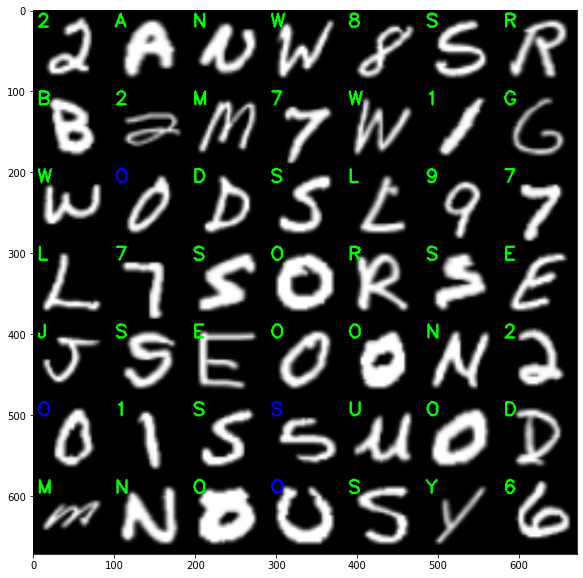

In [7]:
%matplotlib inline
# construct the montage for the images
images = np.array(images).reshape(7, 7, 96, 96, 3).swapaxes(1, 2).reshape(672, 672, 3)

# show the output montage
plt.figure(figsize=(10, 10))
plt.imshow(images)

#Test on hello world image

In [9]:
from imutils.contours import sort_contours
import imutils

In [12]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image2 = cv2.imread("hello_world.png")
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

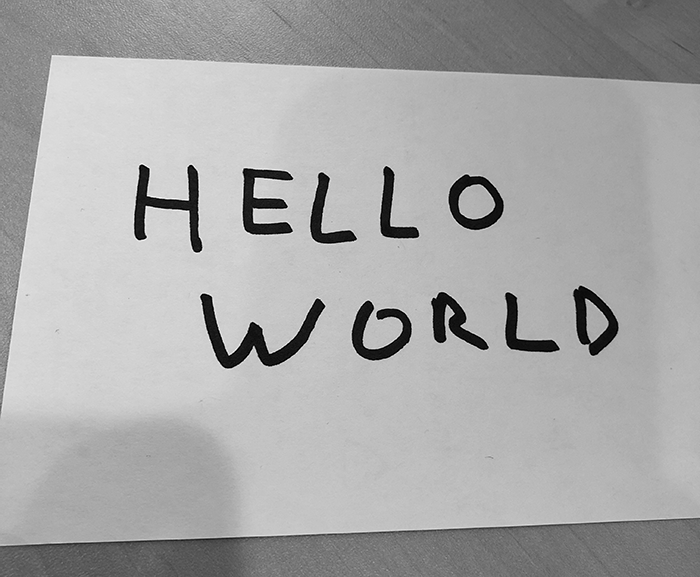

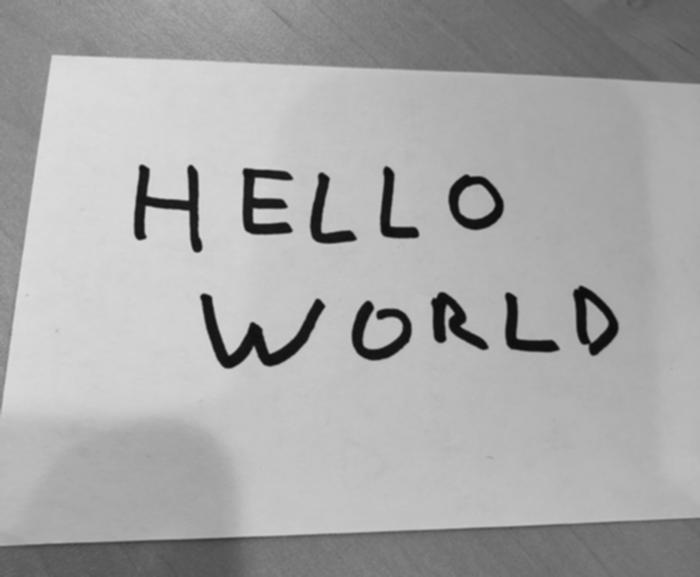

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(gray)
cv2_imshow(blurred)

In [14]:
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts1 = sort_contours(cnts, method="left-to-right")[0]


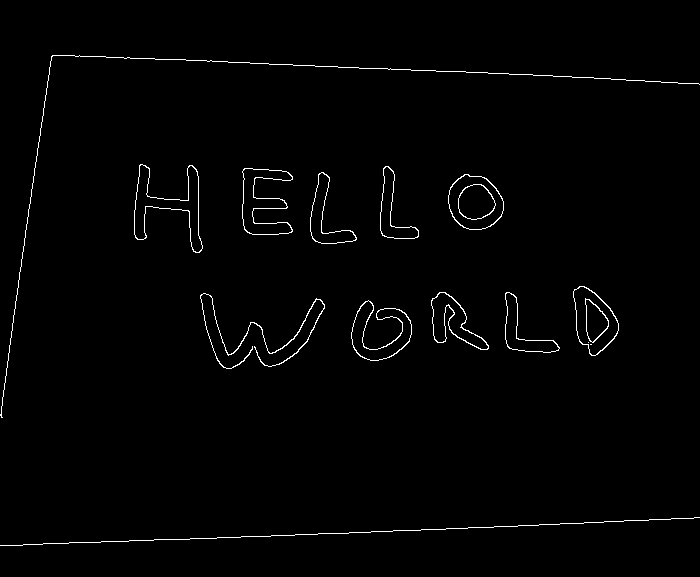

In [16]:
cv2_imshow(edged)

In [15]:
def get_samples(contours, wmin=5, wmax=150, hmin=15, hmax=120):

    chars = []

    # loop over the contours
    for c in cnts:
      # compute the bounding box of the contour
      (x, y, w, h) = cv2.boundingRect(c)

      # filter out bounding boxes, ensuring they are neither too small
      # nor too large
      if (w >= wmin and w <= wmax) and (h >= hmin and h <= hmax):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
          cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape

        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
          thresh = imutils.resize(thresh, width=32)

        # otherwise, resize along the height
        else:
          thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
          left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
          value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))

        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))
      
    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")
    samples = chars

    return boxes, samples

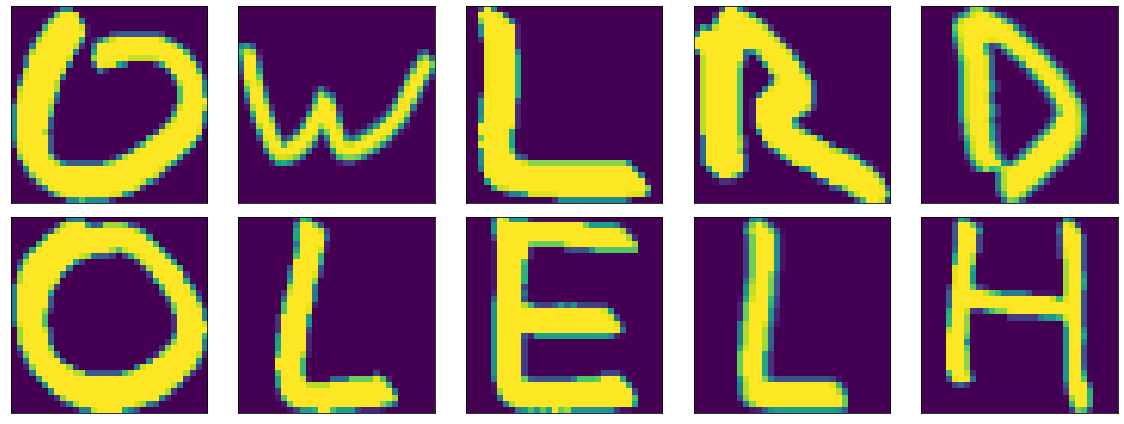

In [17]:
boxes, chars = get_samples(cnts1)


plt.figure(figsize=(16,6))
i = 1
for char in chars:
  plt.subplot(2, 5, i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(char)
  i+=1

plt.tight_layout()

#Try on electrical symbol images

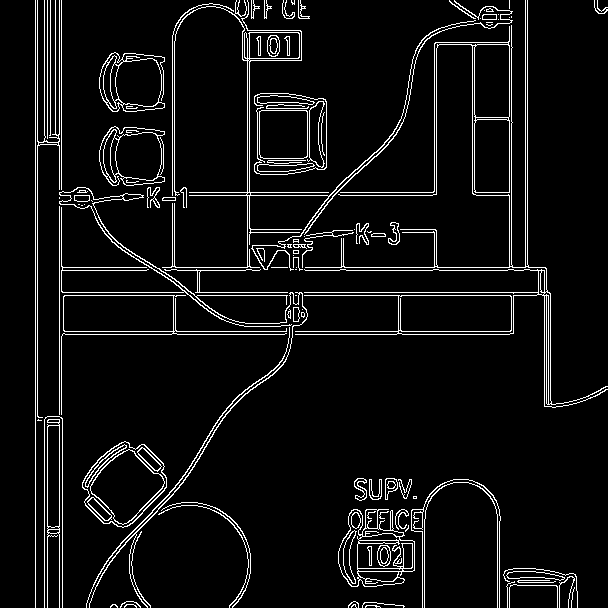

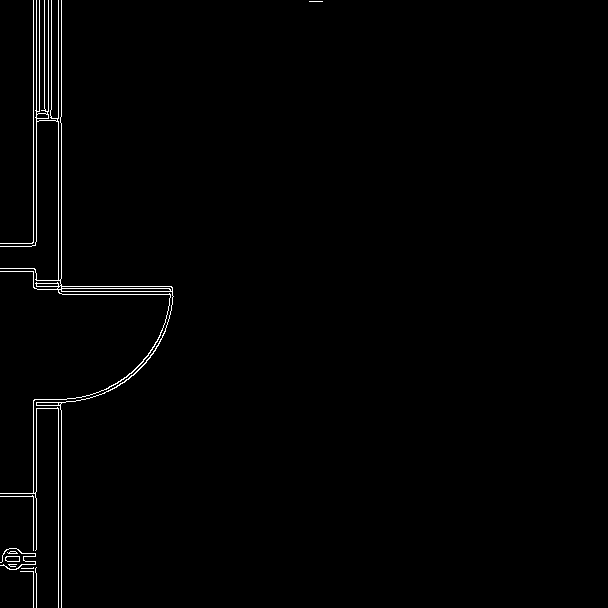

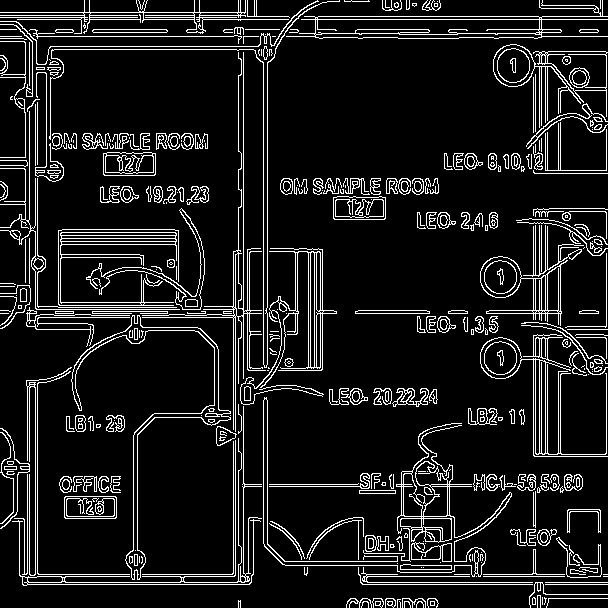

In [21]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
cnts2 = []
imnames = ["symbols_test1.png", "symbols_test2.png", "symbols_test3.png"]

for imname in imnames:
		image3 = cv2.imread(imname)
		gray = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
		blurred = cv2.GaussianBlur(gray, (5, 5), 0)


		# perform edge detection, find contours in the edge map, and sort the
		# resulting contours from left-to-right
		edged = cv2.Canny(blurred, 30, 150)
		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts2.append(sort_contours(cnts, method="left-to-right")[0])

		# cv2_imshow(gray)
		# cv2_imshow(blurred)
		cv2_imshow(edged)
		print()


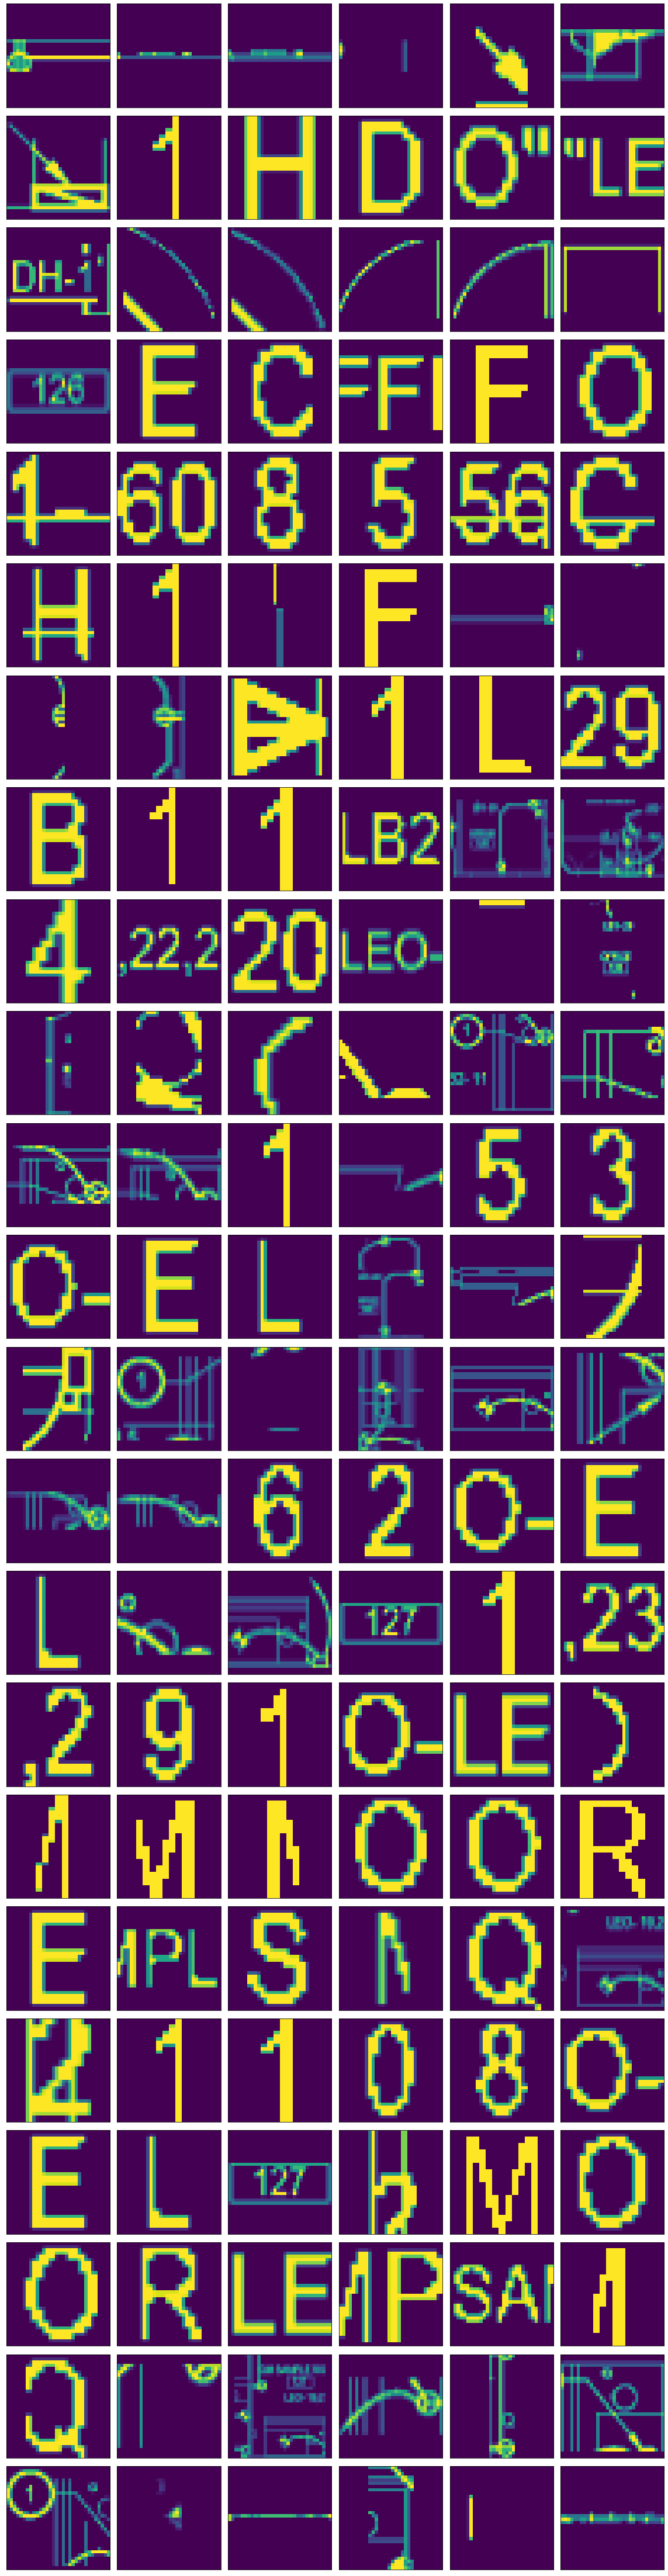

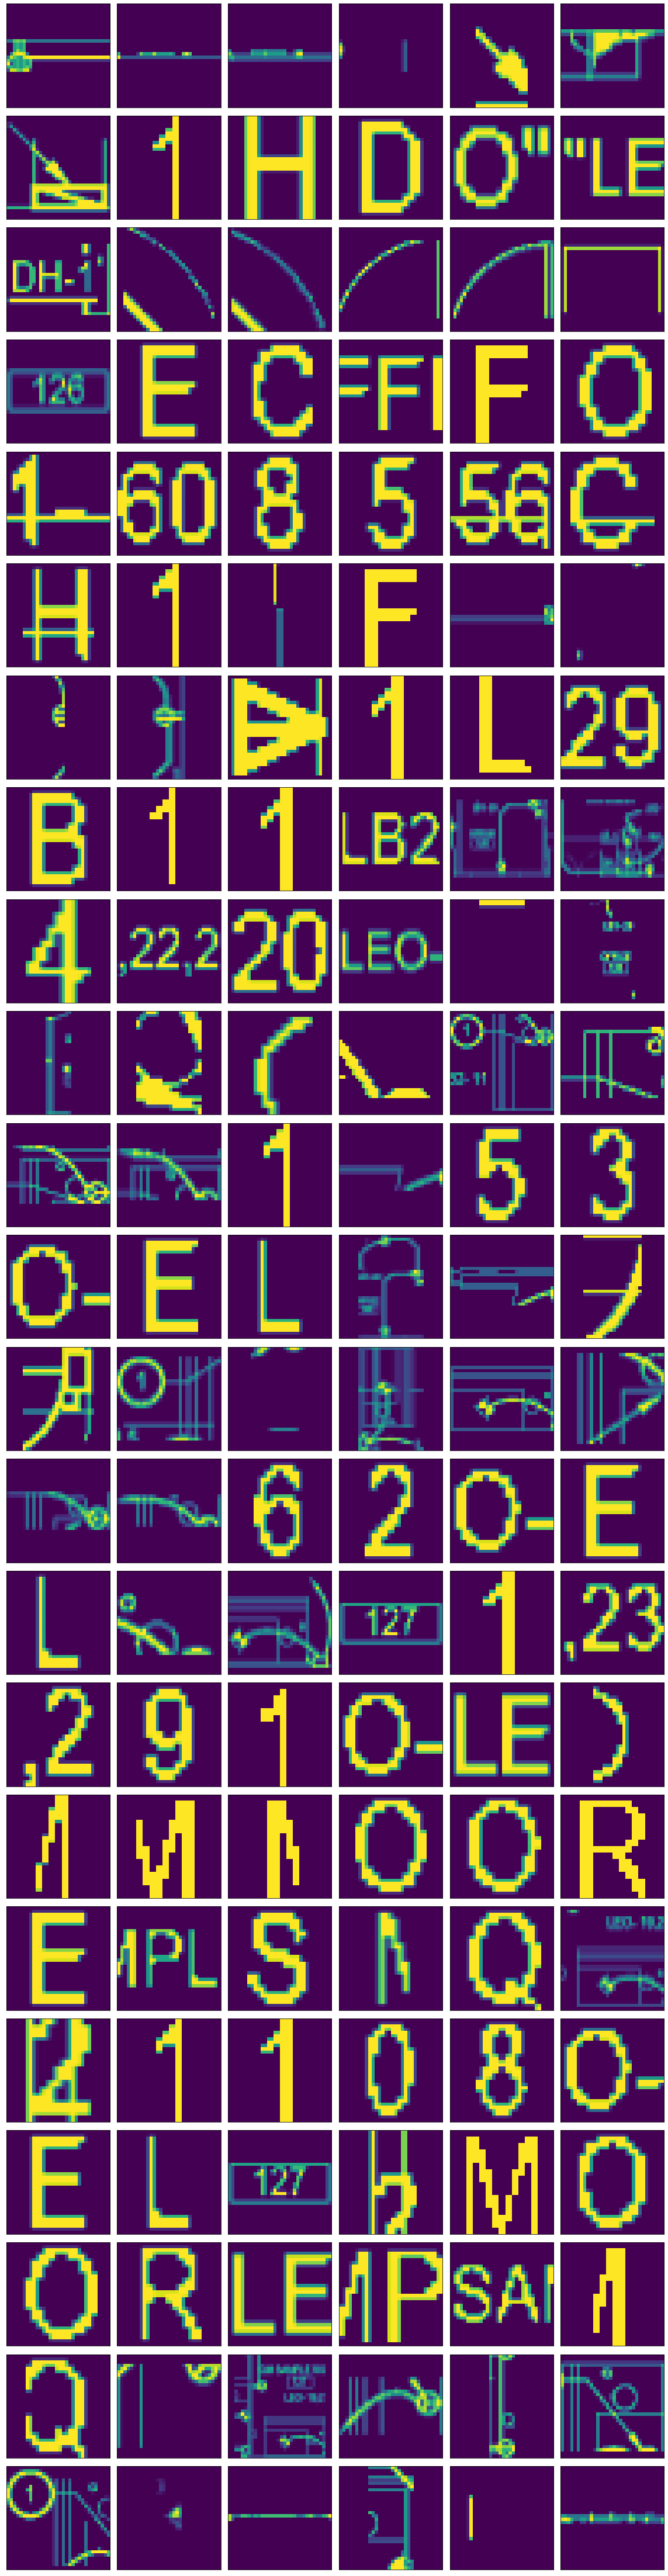

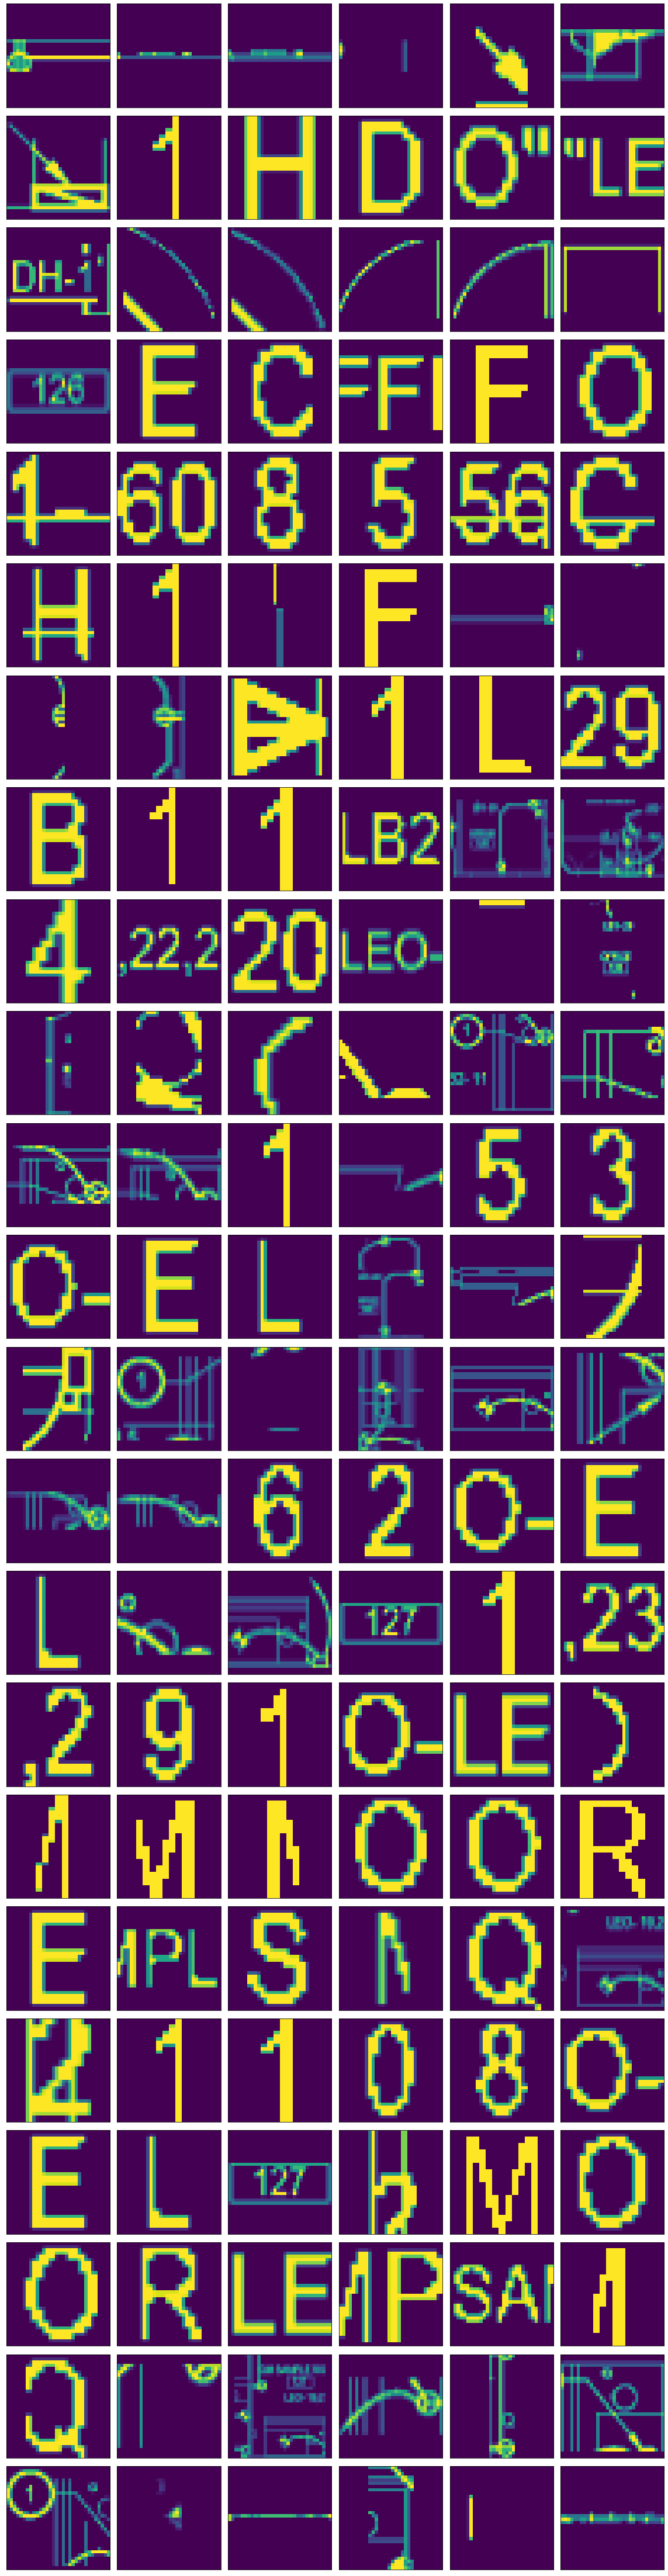

In [22]:
for cntss in cnts2:
    boxes, samples = get_samples(cntss, wmin=5, wmax=300, hmin=15, hmax=300)

    subpplot_nwidth = 6
    figwidth = 16



    subpplot_nheight = int(np.ceil(len(samples)/subpplot_nwidth))
    figheight = figwidth*subpplot_nheight/subpplot_nwidth

    plt.figure(figsize=(figwidth,figheight))
    i = 1
    for sample in samples:
      plt.subplot(subpplot_nheight, subpplot_nwidth, i)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(sample)
      i+=1

    plt.tight_layout()